<center>  <h1> Lecture 3: Differentiable Modules and Minibatching </h1> </center> 
<center> Jillian Fisher, Zaid Harchaoui </center>
    <center> Data 598 (Winter 2023), University of Washington </center>
    <center>  </center>
    
This notebook is inspired by the [D2L book](https://d2l.ai/) and adapted from lecture material created by Krishna Pillutla.

Today we will study two concepts:

- Writing differentiable modules in PyTorch, and, 
- Minibatching for stochastic gradient optimization.


## 1. Differentiable Modules and Functions
We will refer to differentiable programming as DiffProg in short. 

It is important to make a distinction between three types of objects: a mathematical function, a DiffProg function and a differentiable module. 

<img src="https://homes.cs.washington.edu/~pillutla/public/figures/function_math_code.jpeg" width="1200">

- **A mathematical function** is an object $f: \mathbb{R}^{d_1} \to \mathbb{R}^{d_2}$, for instance,
$$
    f(x) = \exp(x) - \sin(x) \,.
$$

- **A DiffProg function** is a piece of code which implements a mathematical function $f: \mathbb{R}^n \to \mathbb{R}^m$ as a program such that: 
    1. $f$ is differentiable (in the [mathematical sense](https://en.wikipedia.org/wiki/Differentiable_function)); this allows computation of derivatives of the output with respect to *each* of the inputs, 
    2. the partial derivatives of $f$ are either computable by automatic differentiation or are explicitly implemented, and, 
    3. the program maintains no *state*
    
- **A differentiable module** is a piece of code which implements a mathematical function $f: \mathbb{R}^{n_1} \times \mathbb{R}^{n_2} \to \mathbb{R}^m$ as a program such that: 
    1. $f$ is differentiable (in the [mathematical sense](https://en.wikipedia.org/wiki/Differentiable_function)); this allows computation of derivatives of the output with respect to *each* of the inputs, 
    2. the partial derivatives of $f$ are either computable by automatic differentiation or are explicitly implemented, and, 
    3. the program is allowed to maintain some parameters as *state*. In other words, it is implemented as a *class*, not a pure *function*.

<img src="https://homes.cs.washington.edu/~pillutla/public/figures/module.jpeg" width="400">


We now distinguish between the inputs and parameters of a mathematical function, similar to a module.
We write $f(x; \theta)$, where the semi-colon separates the input $x$ from the parameters $\theta$. 
Two examples of mathematical functions which we have already coded up include:

- Affine functions: $f(x; \theta) = W^\top x + b$, where $W \in \mathbb{R}^{d_1 \times d_2}$ and $b \in \mathbb{R}^{d_2}$ are the parameters, i.e., $\theta = (W, b)$. 


- Nonlinear functions: $f(x; \theta) = \big(\sigma(x_1), \cdots, \sigma(x_{d_1})\big)$ is a non-linear function $\sigma$, such as the rectified linear unit (ReLU) applied element-wise. This module has no parameters, i.e., $\theta = \varnothing$. 


**Programming Aspects**: First note that the data-types of inputs, parameters and outputs should be a floating type such as `float32` or `float64`. 

*Functions versus Modules*: The difference between DiffProg functions and modules is analogous to the difference between functional programming and object-oriented programming. The module is implemented by a class, which can maintain a state (member variables).

*DiffProg Function/Module Construction*: We can construct a DiffProg function/module in two ways: 

1. compose previously defined differentiable modules and library functions, and, 
1. explicitly code up partial derivatives.

Let us look at each in turn, in the context of PyTorch.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/var/folders/__/vmn4s2rd6755rfl9h22x7pzr0000gn/T/ipykernel_81108/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
def forward(x, y, theta):
    return (torch.dot(x, theta) - y) ** 2

## 1. Differentiable modules from library functions

We can use library functions `torch.norm`, `torch.log`, `torch.exp` and similar floating point functions. A differentiable module in PyTorch is a sub-class of `torch.nn.Module`. This is the most common use case.

PyTorch modules require us to implement two methods:

- the constructor `__init__`: declare and store all the parameters $\theta$ of the module here; we use the special `torch.nn.Parameter` to declare our parameters.
- the `forward` method: pass input $x$ as an input and implement the output $f(x;\theta)$ using library functions or predefined modules. 

Let us start with a simple example. 

In [3]:
import torch
import numpy as np

class LinearModule(torch.nn.Module):  #  1. sub-class torch.nn.Module
    # This way, the new LinearModule class extends torch.nn.Module and 
    # inherits all the functions of torch.nn.Module.
    
    # 2. pass in any number of arguments used to define the module to the constructor
    def __init__(self, input_dim, output_dim): # we pass in input and output dimensions
        super().__init__()  # call the constructor of the super class
        # This initializes the torch.nn.Module class which sets up 
        # attributes such as `.parameters()` required for the code to work.
        
        # 3. Declare all parameters using `torch.nn.Parameter`
        self.weight = torch.nn.Parameter(torch.randn(input_dim, output_dim) * 1/output_dim)
        self.bias = torch.nn.Parameter(torch.zeros(output_dim))
        # At this point, theta = (W, b), where W is represented by self.weight and b by self.bias
        
    # 4. Define the forward function f(x; theta), where x denotes the inputs
    def forward(self, inputs):
        # we expect `inputs` to be of shape (n, input_dim), where n is the number of inputs
        assert len(inputs.shape) == 2 and inputs.shape[1] == self.weight.shape[0]
        # Apply `f(x; theta) = W^T x + b` to each row of `inputs`
        return torch.stack([torch.matmul(self.weight.t(), x) + self.bias for x in inputs])
        
    # NOTE: we have used only library functions here, so we do not need to supply gradient computations here
    # Automatic differentiation does the rest for us

We now define a module and take a tour of the functionality provided by PyTorch.

In [4]:
input_dim = 128
output_dim = 10
linear = LinearModule(input_dim, output_dim)

# Obtain the parameters of the module
parameters = list(linear.parameters()) 
print('Length of parameters:', len(parameters))

# Note that PyTorch automatically sets requires_grad=True for parameters
print('requires_grad:', [param.requires_grad for param in parameters])

Length of parameters: 2
requires_grad: [True, True]


In [5]:
# Modules also give names to the parameters, based on the names of the variables we give
named_parameters = dict(linear.named_parameters())
print('Names of parameters:', named_parameters.keys())

Names of parameters: dict_keys(['weight', 'bias'])


In [6]:
x = torch.rand(25, input_dim)  # some arbitrary input of the correct shape
print('input shape:', x.shape)
# Call the forward function
output = linear.forward(x)
print('output shape:', output.shape)
# Alternatively, we can directly call the module as follows
output = linear(x)
print('output shape:', output.shape)

input shape: torch.Size([25, 128])
output shape: torch.Size([25, 10])
output shape: torch.Size([25, 10])


Modules can be nested. We will now create a new module for a multilayer perceptron (MLP) with a single hidden layer by nesting two linear modules within and ReLU function. 


<img src="https://upload.wikimedia.org/wikipedia/commons/2/28/MultiLayerPerceptron.png" width="400">

<div style="width: 200; height: 200; overflow: hidden">
  <img src="https://upload.wikimedia.org/wikipedia/commons/8/85/ReLU_and_Nonnegative_Soft_Thresholding_Functions.svg" width="800" height="200">
</div>

The only difference is the that we declare "modules" instead of parameters in the constructor `__init__`.


In [7]:
# we use our own definition of the ReLU function
def relu_function(x): # x is an arbitrary tensor
    return torch.where(x >= 0, x, torch.zeros_like(x)) # same behavior as np.where

class TwoLayerPerceptron(torch.nn.Module):  # sub-class `torch.nn.Module`
    def __init__(self, input_dim, hidden_width, output_dim):
        super().__init__()  # initialize super-class (Required for correctness!)
        # register parameters or sub-modules in the constructor
        self.input_to_hidden = LinearModule(input_dim, hidden_width)
        self.hidden_to_output = LinearModule(hidden_width, output_dim)
        
    def forward(self, x): # compute the function f(x; theta) for input x
        hidden = self.input_to_hidden(x)  # apply the first linear module
        hidden = relu_function(hidden)  # apply the non-linearity
        return self.hidden_to_output(hidden)  # apply the final linear module

In [8]:
# test the module
mlp = TwoLayerPerceptron(50, 128, 10)
x = torch.rand(1, 50)
output = mlp(x)
print('output shape:', output.shape)

named_parameters = dict(mlp.named_parameters())
print('parameter names:', named_parameters.keys())

output shape: torch.Size([1, 10])
parameter names: dict_keys(['input_to_hidden.weight', 'input_to_hidden.bias', 'hidden_to_output.weight', 'hidden_to_output.bias'])


Let us now try to train this MLP using the FashionMNIST dataset from last week.

X_train.shape = torch.Size([6000, 28, 28])
n_train: 6000, n_test: 10000
Image size: torch.Size([28, 28])


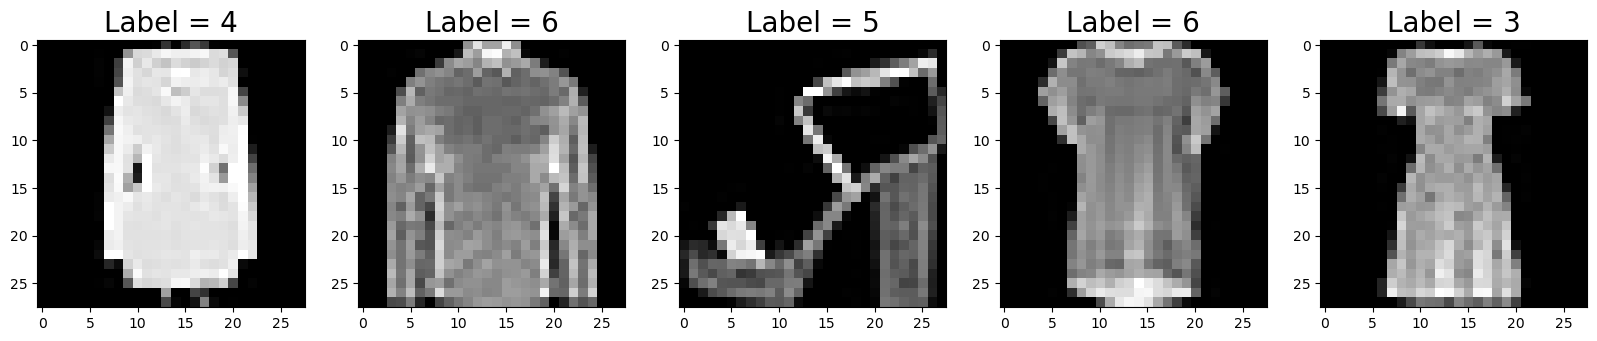

In [9]:
from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt

# download dataset (~117M in size)
train_dataset = FashionMNIST('./data', train=True, download=True)
X_train = train_dataset.data # torch tensor of type uint8
y_train = train_dataset.targets # torch tensor of type Long
test_dataset = FashionMNIST('./data', train=False, download=True)
X_test = test_dataset.data
y_test = test_dataset.targets

# choose a subsample of 10% of the data:
idxs_train = torch.from_numpy(
    np.random.choice(X_train.shape[0], replace=False, size=X_train.shape[0]//10)).long()
X_train, y_train = X_train[idxs_train], y_train[idxs_train]
# idxs_test = torch.from_numpy(
#     np.random.choice(X_test.shape[0], replace=False, size=X_test.shape[0]//10))
# X_test, y_test = X_test[idxs_test], y_test[idxs_test]

print(f'X_train.shape = {X_train.shape}')
print(f'n_train: {X_train.shape[0]}, n_test: {X_test.shape[0]}')
print(f'Image size: {X_train.shape[1:]}')

f, ax = plt.subplots(1, 5, figsize=(20, 4))
for i, idx in enumerate(np.random.choice(X_train.shape[0], 5)):
    ax[i].imshow(X_train[idx], cmap='gray', vmin=0, vmax=255)
    ax[i].set_title(f'Label = {y_train[idx]}', fontsize=20)
    
# Normalize dataset: pixel values lie between 0 and 255
# Normalize them so the pixelwise mean is zero and standard deviation is 1

X_train = X_train.float()  # convert to float32
X_train = X_train.view(-1, 784)
mean, std = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - mean[None, :]) / (std[None, :] + 1e-6)  # avoid divide by zero

X_test = X_test.float()
X_test = X_test.view(-1, 784)
X_test = (X_test - mean[None, :]) / (std[None, :] + 1e-6)

n_class = np.unique(y_train).shape[0]

In [10]:
from torch.nn.functional import cross_entropy

def compute_objective(mlp, X, y):
    """ Compute the multinomial logistic loss. 
        mlp is a module
        X of shape (n, d) and y of shape (n,)
    """
    # send 
    score = mlp(X)
    # PyTorch's function cross_entropy computes the multinomial logistic loss
    return cross_entropy(input=score, target=y, reduction='mean') 

@torch.no_grad()
def compute_accuracy(mlp, X, y):
    """ Compute the  accuracy
        ws is a list of tensors of consistent shapes 
        X of shape (n, d) and y of shape (n,)
    """
    score = mlp(X)
    predictions = torch.argmax(score, axis=1)  # class with highest score is predicted
    return (predictions == y).sum() * 1.0 / y.shape[0]

@torch.no_grad()
def compute_logs(mlp, verbose=False):
    train_loss = compute_objective(mlp, X_train, y_train)
    test_loss = compute_objective(mlp, X_test, y_test)
    train_accuracy = compute_accuracy(mlp, X_train, y_train)
    test_accuracy = compute_accuracy(mlp, X_test, y_test)
    if verbose:
        print(('Train Loss = {:.3f}, Train Accuracy = {:.3f}, ' + 
               'Test Loss = {:.3f}, Test Accuracy = {:.3f}').format(
                train_loss.item(), train_accuracy.item(), 
                test_loss.item(), test_accuracy.item())
    )
    return (train_loss, train_accuracy, test_loss, test_accuracy)

def sgd_one_pass(mlp, X, y, learning_rate, verbose=False):
    num_examples = X.shape[0]
    average_loss = 0.0
    for i in range(num_examples):
        idx = np.random.choice(X.shape[0])
        # compute the objective. 
        # Note: This function requires X to be of shape (n,d). In this case, n=1 
        objective = compute_objective(mlp, X[idx:idx+1], y[idx:idx+1]) 
        average_loss = 0.99 * average_loss + 0.01 * objective.item()
        if verbose and (i+1) % 100 == 0:
            print(average_loss)
        
        # compute the gradient using automatic differentiation
        gradients = torch.autograd.grad(outputs=objective, inputs=mlp.parameters())
        
        # perform SGD update. IMPORTANT: Make the update inplace!
        with torch.no_grad():
            for (w, g) in zip(mlp.parameters(), gradients):
                w -= learning_rate * g
    return mlp

In [11]:
learning_rate = 5e-3

logs = []

mlp = TwoLayerPerceptron(input_dim=784, hidden_width=64, output_dim=10)
print(f'Iteration 0', end=', ')
logs.append(compute_logs(mlp, verbose=True))

for j in range(5):
    mlp = sgd_one_pass(mlp, X_train, y_train, learning_rate, verbose=False)
    print(f'Iteration {j+1}', end=', ')
    logs.append(compute_logs(mlp, verbose=True))


Iteration 0, Train Loss = 2.357, Train Accuracy = 0.114, Test Loss = 2.363, Test Accuracy = 0.103
Iteration 1, Train Loss = 0.494, Train Accuracy = 0.824, Test Loss = 0.595, Test Accuracy = 0.789
Iteration 2, Train Loss = 0.394, Train Accuracy = 0.861, Test Loss = 0.552, Test Accuracy = 0.816
Iteration 3, Train Loss = 0.303, Train Accuracy = 0.892, Test Loss = 0.512, Test Accuracy = 0.829
Iteration 4, Train Loss = 0.279, Train Accuracy = 0.899, Test Loss = 0.530, Test Accuracy = 0.832
Iteration 5, Train Loss = 0.261, Train Accuracy = 0.908, Test Loss = 0.543, Test Accuracy = 0.823


## 2. DiffProg by coding up derivatives

Let us now look at how to code up our own derivatives in PyTorch for the special case of a function whose output is one-dimensional. Consider a function $f: \mathbb{R}^{d_1} \times \cdots \mathbb{R}^{d_n} \to \mathbb{R}$ with $n$ inputs. 

DiffProg function with hard-coded derivatives are implemented in PyTorch by sub-classing `torch.autograd.Function`. We need implement two methods:

- the `forward` method: pass the inputs $x_1, \cdots, x_n$ and compute the output $f(x_1, \cdots, x_n)$,
- the `backward` method: pass as input a scalar $z$ and return $z \frac{\partial}{\partial x_1} f(x_1, \cdots, x_n), \cdots, z \frac{\partial}{\partial x_n} f(x_1, \cdots, x_n)$.

Both `forward` and `backward` are implemented as *static* methods, so there is no state here. Recall that instance methods (non-static) are called directly on an object, which is an instantiation of a class and has a state, while static methods do not have access to an object (and are hence stateless).

The backward function actually implements the chain rule. Indeed, the derivatives of the composition $(g \circ f)(x_1, \cdots, x_n)$ are 
$$
     \frac{\partial}{\partial x_i} g\big(f(x_1, \cdots, x_n)\big) 
     = g'\big(f(x_1, \cdots, x_n)\big) \times \frac{\partial}{\partial x_i} f(x_1, \cdots, x_n).
$$

Automatic differentiation takes care of applying the chain rule by passing in $z = g'\big(f(x_1, \cdots, x_n)\big)$ to the `backward` method during the gradient computation. 

Let us start with a simple example, $f(x) = 2^x$. We will implement $f'(x) = 2^x \, \log(2) = f(x) \, \log(2)$ in the backward function. 

In [12]:
import math

class MyPowerFunction(torch.autograd.Function): # subclass `torch.autograd.Function`
    
    @staticmethod  # both forward and backward are static methods
    def forward(ctx, x):  # `ctx` allows us to save intermediate computations for the derivative
        y = 2**x
        ctx.save_for_backward(y)  # save the result
        return y
    
    @staticmethod 
    def backward(ctx, z): # use ctx retrieve the saved `y` here 
        print('Note: Using the backward function we defined!')
        y = ctx.saved_tensors[0]  # saved_tensors is a tuple. We extract its first element
        fprime = y * math.log(2)  # derivative
        return z * fprime  # return z times the derivative

Let us try this out now.

In [13]:
x = torch.rand(1, requires_grad=True) 
print('x = ', x)

# call the function using the `apply` method
two_power_x = MyPowerFunction.apply(x) #object
print(two_power_x)

# use autograd to compute the derivative
derivative_custom = torch.autograd.grad(outputs=two_power_x, inputs=[x])[0]  # torch.autograd.grad return a tuple of length 1
print('derivative =', derivative_custom)

x =  tensor([0.6240], requires_grad=True)
tensor([1.5411], grad_fn=<MyPowerFunctionBackward>)
Note: Using the backward function we defined!
derivative = tensor([1.0682])


Let us compare that against the result returned by PyTorch's automatic differentiation.

In [14]:
two_power_x_again = 2 ** x # tensor
print(two_power_x_again)

# use autograd to compute the derivative
derivative_torch = torch.autograd.grad(outputs=two_power_x_again, inputs=[x])[0]  # torch.autograd.grad return a tuple of length 1
print('derivative =', derivative_torch)

tensor([1.5411], grad_fn=<PowBackward1>)
derivative = tensor([1.0682])


You can read the documentation of `torch.autograd.Function` [here](https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function).

## Minibatch Stochastic Gradient Descent (SGD)

Minibatch SGD extrapolates between gradient descent (which requires $n$ gradient computations per update) and stochastic gradient descent (which requires $1$ gradient computation per update) by using $B$ gradient computations per update. 

Consider minimizing $f : \mathbb{R}^d \to \mathbb{R}$ defined by 
$$
    f(w) = \frac{1}{n} \sum_{i=1}^n L(x_i, y_i; w) \,,
$$

In other words, the algorithm starts from some initial $w_0$ and iterates

- sample $B$ indices $i_1, \cdots, i_B$ from $\{1, \cdots, n\}$, 
- calculate the stochastic gradient $g_t = \frac{1}{B} \sum_{b=1}^B \nabla L(x_{i_b}, y_{i_b}; w_t)$
- update $w_{t+1} = w_t - \eta g_t$

Gradient descent is at the extreme $B = n$ and stochastic gradient descent at $B= 1$. 

The advantages of such an approach are:

- Reduced variance: by averaging more items, we reduce the variance of the gradient estimate. We will revisit this in the homework. 
- With specialized hardware such as GPUs, the time to compute a minibatch stochastic gradient is around the same as that of a stochastic gradient with $B=1$ (the constraint here is the GPU memory).

Here we will demonstrate the effect of the minibatch size on the divergent learning rate. We will use the MLP we coded up above. 


In [15]:
def minibatch_sgd_one_pass(mlp, X, y, learning_rate, batch_size, verbose=False):
    num_examples = X.shape[0]
    average_loss = 0.0
    num_updates = int(round(num_examples / batch_size))
    for i in range(num_updates):
        idxs = np.random.choice(X.shape[0], size=(batch_size,)) # draw `batch_size` many samples
        # compute the objective. 
        objective = compute_objective(mlp, X[idxs], y[idxs]) 
        average_loss = 0.99 * average_loss + 0.01 * objective.item()
        if verbose and (i+1) % 100 == 0:
            print(average_loss)
        
        # compute the gradient using automatic differentiation
        gradients = torch.autograd.grad(outputs=objective, inputs=mlp.parameters())
        
        # perform SGD update. IMPORTANT: Make the update inplace!
        with torch.no_grad():
            for (w, g) in zip(mlp.parameters(), gradients):
                w -= learning_rate * g
    return mlp

In [16]:
learning_rate = 0.32

logs = []

mlp = TwoLayerPerceptron(input_dim=784, hidden_width=64, output_dim=10)
logs.append(compute_logs(mlp, verbose=True))

batch_size = 64

for _ in range(batch_size):  # run multiple passes because our sub-sampled dataset is too small
    mlp = minibatch_sgd_one_pass(mlp, X_train, y_train, learning_rate, batch_size=batch_size, verbose=True)


Train Loss = 2.322, Train Accuracy = 0.097, Test Loss = 2.319, Test Accuracy = 0.092


Let us fill out this table with which learning rates work and which ones do not.

- 'X' denotes a learning rate which causes divergence.
- 'Y' denotes a learning rate which does not cause divergence. 



| B, $\eta$   | $\eta = 0.02$| $\eta = 0.04$ | $\eta = 0.08$ | $\eta = 0.16$ | $\eta = 0.32$ | $\eta = 0.64$ |
| ----------- | ------------ | ------------- | ------------- | ------------- | ------------- | ------------- |
| $B = 1$     |       X      |       X       |       X       |       X       |      X        |       X       |
| $B = 2$     |       Y      |               |               |               |               |               |
| $B = 4$     |              |               |               |               |               |               |
| $B = 8$     |              |               |               |               |               |               |
| $B = 16$    |              |               |               |               |               |               |
| $B = 32$    |              |               |               |               |               |               |
| $B = 64$    |              |               |               |               |               |               |

### Data augmentation

Typical neural network pipelines use data augmentations. In particular, we take one image and produce many other images which are small variants. This makes the model more robust to small changes in the patters we are trying to capture. 

Let us consider an example.

/Users/jillianfisher/opt/miniconda3/envs/data598/lib/python3.8/site-packages/torchvision/transforms/transforms.py:852: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


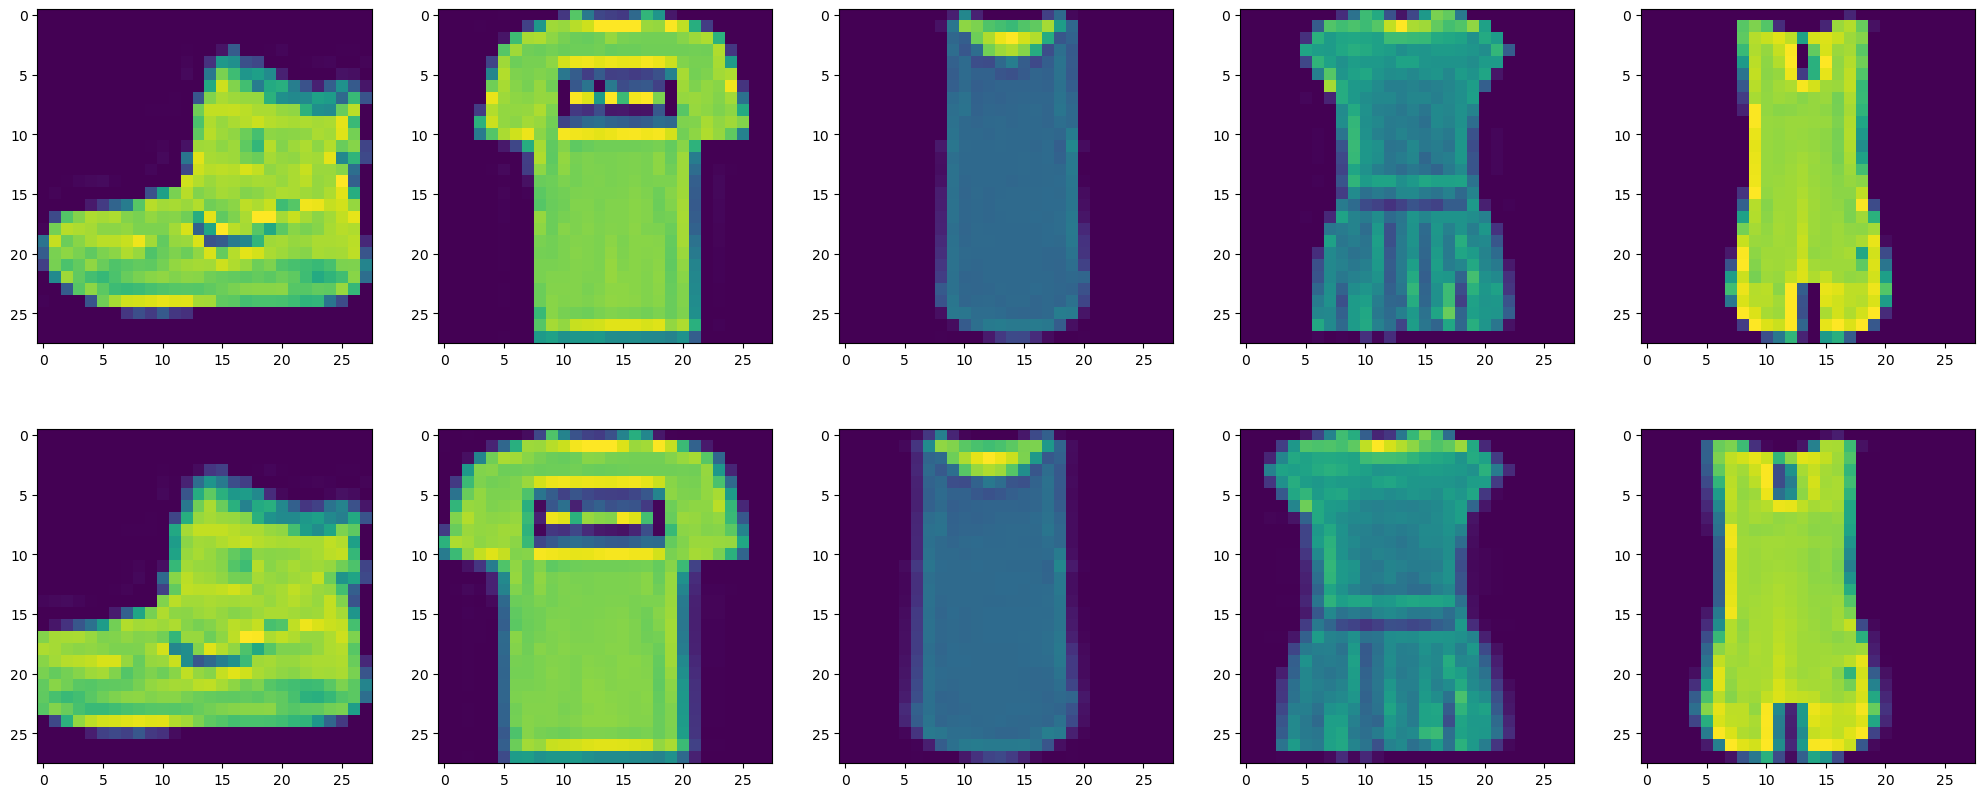

In [17]:
import torchvision.transforms as transforms

images = train_dataset.data[:5]
my_transform = transforms.RandomResizedCrop((28, 28), scale=(0.75, 1.0), ratio=(0.75, 1.33), interpolation=2)
images_transformed = my_transform(images)

f, ax = plt.subplots(2, 5, figsize=(25, 10))

for i in range(5):
    ax[0, i].imshow(images[i])
    ax[1, i].imshow(images_transformed[i])

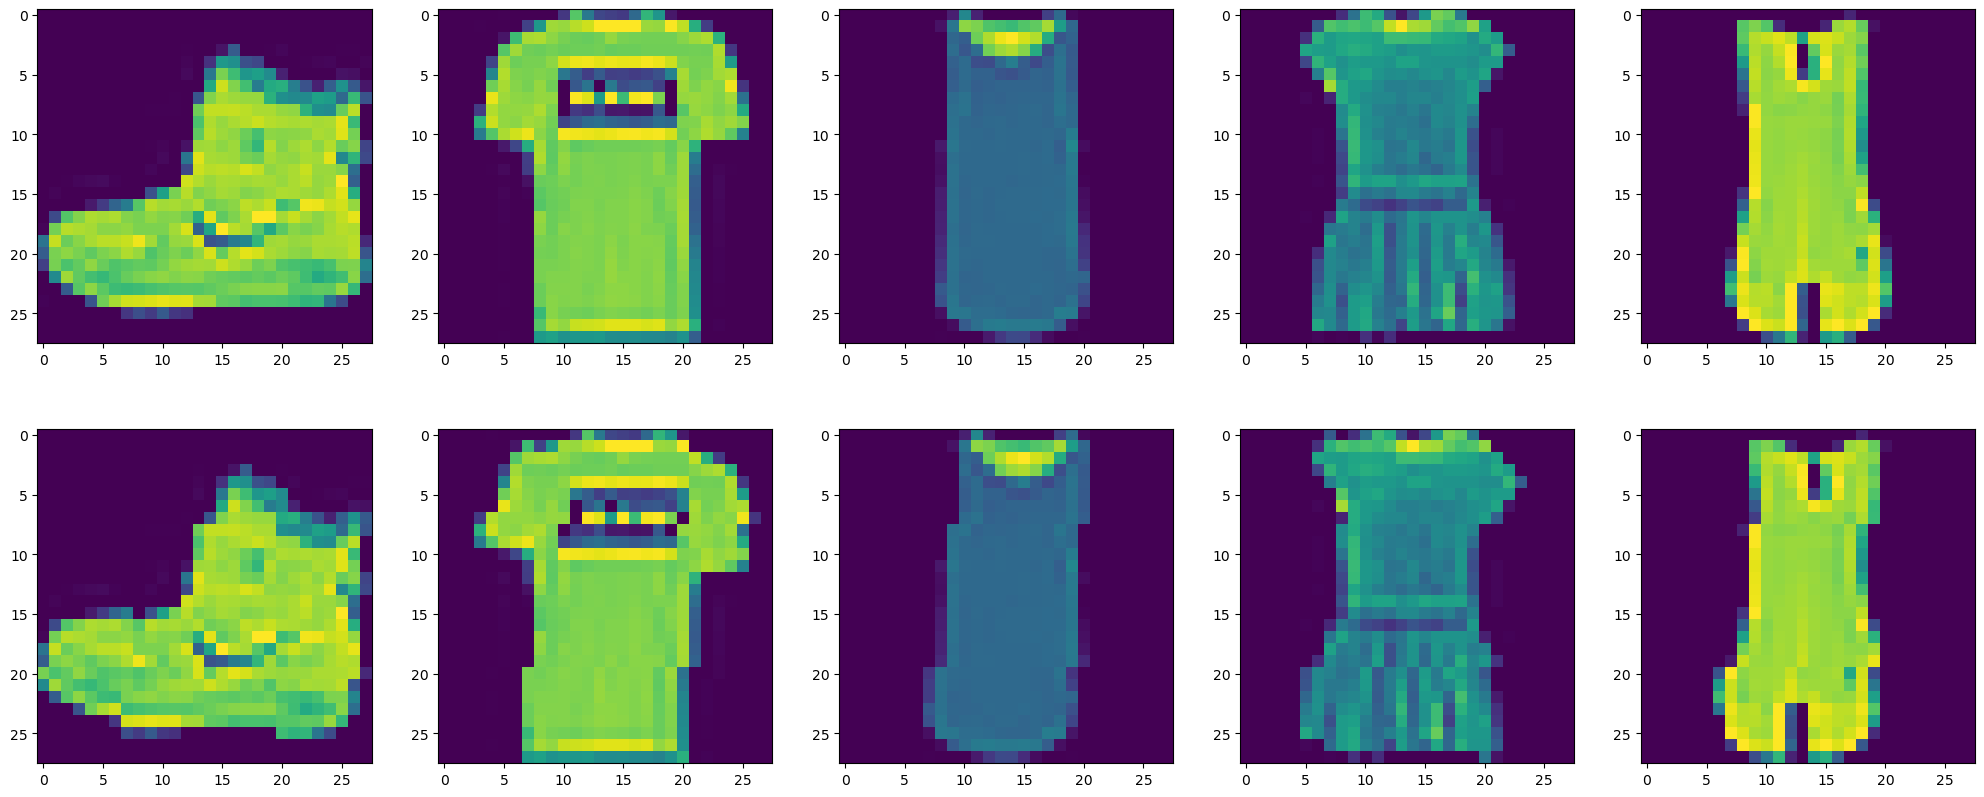

In [18]:
images = train_dataset.data[:5]
my_transform = transforms.RandomRotation((-25, 25)) # random roatation in -25 to 25 degrees
images_transformed = my_transform(images)

f, ax = plt.subplots(2, 5, figsize=(25, 10))

for i in range(5):
    ax[0, i].imshow(images[i])
    ax[1, i].imshow(images_transformed[i])

In [19]:
# Use this for your homework

def transform_selected_data(X):
    # X is of shape (B, 784), where B is the batch_size
    X = X.view(-1, 28, 28)  # reshape to 28x28
    transform1 = transforms.RandomResizedCrop((28, 28), scale=(0.75, 1.0), ratio=(0.75, 1.33), interpolation=2)
    transform2 = transforms.RandomRotation((-10, 10))
    X_transformed = transform2(transform1(X))
    return X_transformed.view(-1, 784) # reshape into a vector


# call, e.g., as `transform_selected_data(X_train[:10])`

## Convolutional neural network

A different type of neural networks appropriate for images or audio signals are called convolutional neural networks (ConvNets). It is also made up of a chain of compositions of linear operations and non-linear maps. The difference is that the linear operation is a convolution, which respects the spatial structure of the images or the temporal structure of audio. 

We will give the precise definition of ConvNets next week; for now we simply use them as just another type of a deep net.

<img src="https://upload.wikimedia.org/wikipedia/commons/6/68/Conv_layer.png" width=500>


### Using a ConvNet
In today's lab, we will go through the usual exercise of figuring out the divergent learning rate, etc. on the following ConvNet. Simply replace the *TwoLayerPercptron* class from above with the following convolutional neural network.


In [20]:
class MyConvNet(torch.nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv_ensemble_1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=5, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2))
        self.conv_ensemble_2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, kernel_size=5, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2))
        self.fully_connected_layer = torch.nn.Linear(7*7*32, 10)
        
    def forward(self, x):
        x = x.view(-1, 1, 28, 28)  # reshape input; convolutions need a channel
        out = self.conv_ensemble_1(x)  # first convolution + relu + pooling
        out = self.conv_ensemble_2(out) # second convolution + relu + pooling
        out = out.view(out.shape[0], -1)  # flatten output
        out = self.fully_connected_layer(out)  # output layer
        return out